In [1]:
#Müşterilerin davranışlarını tahmin etmeye çalışıyoruz

In [2]:
#!pip install pyspark

In [3]:
#!pip install findspark


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#from google.colab import files
#uploaded=files.upload()



from pyspark import SparkContext
import findspark
findspark.init()
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.sql import SQLContext
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_breast_cancer
from pandas import DataFrame, Series 
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession
from pyspark.sql import Row
import collections
from pyspark import SparkConf,SparkContext

pd.set_option("display.max_columns", None)

In [5]:
df=pd.read_csv("churn.csv", encoding="ISO-8859-1",)

In [6]:
df.head()

,Unnamed: 0,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
0,0,Cameron Williams,42.0,11066.80,0,7.22,8.0,1
1,1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,1
2,2,Eric Lozano,38.0,12884.75,0,6.67,12.0,1
3,3,Phillip White,42.0,8010.76,0,6.71,10.0,1
4,4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,1


In [7]:
df.tail()

,Unnamed: 0,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
895,895,Paul Miller,42.0,12800.82,1,3.62,8.0,0
896,896,Natalie Hodges,52.0,9893.92,0,6.91,7.0,0
897,897,Ana Smith,45.0,12056.18,0,5.46,4.0,0
898,898,Justin Leonard,51.0,6517.93,1,5.47,10.0,0
899,899,Joseph Williams,39.0,9315.60,1,5.02,10.0,0


In [8]:
df.shape

(900, 8)

In [9]:
df.columns

Index(['Unnamed: 0', 'Names', 'Age', 'Total_Purchase', 'Account_Manager',
       'Years', 'Num_Sites', 'Churn'],
      dtype='object')

* Total_Purchase Toplam Satın Alma
* Account_Manager Hesap Yöneticisi
* Num_Sites Site Sayısı

In [10]:
df["Names"].nunique()

899

In [11]:
df["Age"].unique()

array([42., 41., 38., 37., 48., 44., 32., 43., 40., 30., 45., 53., 46.,
       56., 35., 55., 54., 36., 50., 58., 49., 47., 52., 39., 51., 29.,
       34., 26., 31., 33., 65., 28., 60., 25., 27., 22.])

In [12]:
df["Total_Purchase"].unique()

array([11066.8 , 11916.22, 12884.75,  8010.76,  9191.58, 10356.02,
       11331.58,  9885.12, 14062.6 ,  8066.94, 11575.37,  8771.02,
        8988.67,  8283.32,  6569.87, 10494.82,  8213.41, 11226.88,
        5515.09,  8046.4 ,  9771.22, 12217.95,  9381.12, 10474.94,
       11158.5 ,  8207.1 , 12403.81, 10041.13, 12721.55,  8284.89,
       10661.48, 10793.11,  9322.44,  9814.22, 11740.  , 14383.36,
       11887.39, 10367.08,  8198.06,  7777.37, 11699.26, 16838.94,
       10484.33,  8736.06, 10850.78,  8601.01, 11170.06, 11185.62,
        9793.42, 12524.68, 12682.9 , 14036.28, 10179.92, 12772.72,
       12122.19,  9922.3 ,  4771.65, 10827.96,  8642.01,  6749.49,
        6447.99, 11091.21,  5024.52, 12376.37, 12458.8 ,  7222.35,
       11758.69,  8772.  ,  7351.38,  7960.64, 13365.66,  8617.98,
       11849.13, 11145.95,  9577.42, 10110.4 ,  8024.08,  8563.24,
        9403.58, 12520.53, 13655.59, 12680.46,  8429.65, 11424.  ,
       13725.55,  7396.1 ,  8100.43, 10400.88,  8625.96,  5192

In [13]:
df["Account_Manager"].unique()

array([0, 1], dtype=int64)

In [14]:
df["Years"].unique()

array([7.22, 6.5 , 6.67, 6.71, 5.56, 5.12, 5.23, 6.92, 5.46, 7.11, 5.22,
       6.64, 4.84, 5.1 , 4.3 , 6.81, 7.35, 8.08, 6.85, 5.69, 5.81, 5.79,
       6.78, 6.4 , 4.86, 4.26, 4.42, 7.61, 5.18, 5.6 , 5.16, 4.65, 2.69,
       5.45, 4.97, 7.84, 5.83, 6.45, 5.04, 4.81, 6.99, 6.66, 8.84, 5.51,
       5.63, 5.65, 7.76, 6.26, 5.98, 4.58, 7.25, 5.97, 6.46, 7.53, 5.07,
       3.77, 4.2 , 4.76, 5.88, 5.52, 5.9 , 8.11, 6.01, 6.41, 6.97, 6.43,
       5.76, 2.72, 8.36, 6.2 , 6.8 , 5.87, 5.86, 5.78, 4.08, 5.29, 6.3 ,
       2.05, 5.92, 7.1 , 5.09, 4.11, 4.92, 5.84, 6.27, 3.26, 5.53, 6.83,
       7.38, 6.36, 5.7 , 8.51, 4.57, 7.16, 4.78, 6.68, 6.95, 7.8 , 5.31,
       4.16, 8.82, 7.31, 5.43, 5.64, 5.59, 5.3 , 4.64, 4.75, 5.42, 6.62,
       8.97, 7.39, 4.59, 5.72, 7.01, 5.27, 6.54, 6.61, 5.57, 5.66, 4.83,
       6.82, 5.54, 6.84, 6.23, 5.39, 6.53, 4.43, 4.44, 3.99, 3.68, 4.6 ,
       3.96, 4.93, 4.13, 2.23, 4.95, 6.35, 5.03, 4.38, 5.71, 1.87, 5.93,
       5.89, 7.78, 1.62, 4.34, 4.51, 5.82, 2.88, 5.

In [15]:
df["Num_Sites"].unique()

array([ 8., 11., 12., 10.,  9., 13., 14.,  7.,  6.,  5.,  4.,  3.])

In [16]:
df["Churn"].unique()

array([1, 0], dtype=int64)

In [17]:
df.isnull().sum()    #hiç boş verim yok

Unnamed: 0         0
Names              0
Age                0
Total_Purchase     0
Account_Manager    0
Years              0
Num_Sites          0
Churn              0
dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       900 non-null    int64  
 1   Names            900 non-null    object 
 2   Age              900 non-null    float64
 3   Total_Purchase   900 non-null    float64
 4   Account_Manager  900 non-null    int64  
 5   Years            900 non-null    float64
 6   Num_Sites        900 non-null    float64
 7   Churn            900 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 56.4+ KB


In [19]:
df["Num_Sites"]=df["Num_Sites"].astype(float)
df["Years"]=df["Years"].astype(float)
df["Total_Purchase"]=df["Total_Purchase"].astype(float)
df["Age"]=df["Age"].astype(float)
df["Account_Manager"]=df["Account_Manager"].astype(float)
df["Churn"]=df["Churn"].astype(float)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       900 non-null    int64  
 1   Names            900 non-null    object 
 2   Age              900 non-null    float64
 3   Total_Purchase   900 non-null    float64
 4   Account_Manager  900 non-null    float64
 5   Years            900 non-null    float64
 6   Num_Sites        900 non-null    float64
 7   Churn            900 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 56.4+ KB


In [21]:
df

,Unnamed: 0,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
0,0,Cameron Williams,42.0,11066.80,0.0,7.22,8.0,1.0
1,1,Kevin Mueller,41.0,11916.22,0.0,6.50,11.0,1.0
2,2,Eric Lozano,38.0,12884.75,0.0,6.67,12.0,1.0
3,3,Phillip White,42.0,8010.76,0.0,6.71,10.0,1.0
4,4,Cynthia Norton,37.0,9191.58,0.0,5.56,9.0,1.0
...,...,...,...,...,...,...,...,...
895,895,Paul Miller,42.0,12800.82,1.0,3.62,8.0,0.0
896,896,Natalie Hodges,52.0,9893.92,0.0,6.91,7.0,0.0
897,897,Ana Smith,45.0,12056.18,0.0,5.46,4.0,0.0
898,898,Justin Leonard,51.0,6517.93,1.0,5.47,10.0,0.0


In [22]:
del df["Names"]

In [23]:
df

,Unnamed: 0,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
0,0,42.0,11066.80,0.0,7.22,8.0,1.0
1,1,41.0,11916.22,0.0,6.50,11.0,1.0
2,2,38.0,12884.75,0.0,6.67,12.0,1.0
3,3,42.0,8010.76,0.0,6.71,10.0,1.0
4,4,37.0,9191.58,0.0,5.56,9.0,1.0
...,...,...,...,...,...,...,...
895,895,42.0,12800.82,1.0,3.62,8.0,0.0
896,896,52.0,9893.92,0.0,6.91,7.0,0.0
897,897,45.0,12056.18,0.0,5.46,4.0,0.0
898,898,51.0,6517.93,1.0,5.47,10.0,0.0


In [24]:
df=df.drop(["Unnamed: 0" ], axis=1)

In [25]:
df.head()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
0,42.0,11066.80,0.0,7.22,8.0,1.0
1,41.0,11916.22,0.0,6.50,11.0,1.0
2,38.0,12884.75,0.0,6.67,12.0,1.0
3,42.0,8010.76,0.0,6.71,10.0,1.0
4,37.0,9191.58,0.0,5.56,9.0,1.0


In [26]:
df.describe()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,41.816667,10062.824033,0.481111,5.273156,8.587778,0.166667
std,6.127560,2408.644532,0.499921,1.274449,1.764836,0.372885
min,22.000000,100.000000,0.000000,1.000000,3.000000,0.000000
25%,38.000000,8497.122500,0.000000,4.450000,7.000000,0.000000
50%,42.000000,10045.870000,0.000000,5.215000,8.000000,0.000000
75%,46.000000,11760.105000,1.000000,6.110000,10.000000,0.000000
max,65.000000,18026.010000,1.000000,9.150000,14.000000,1.000000


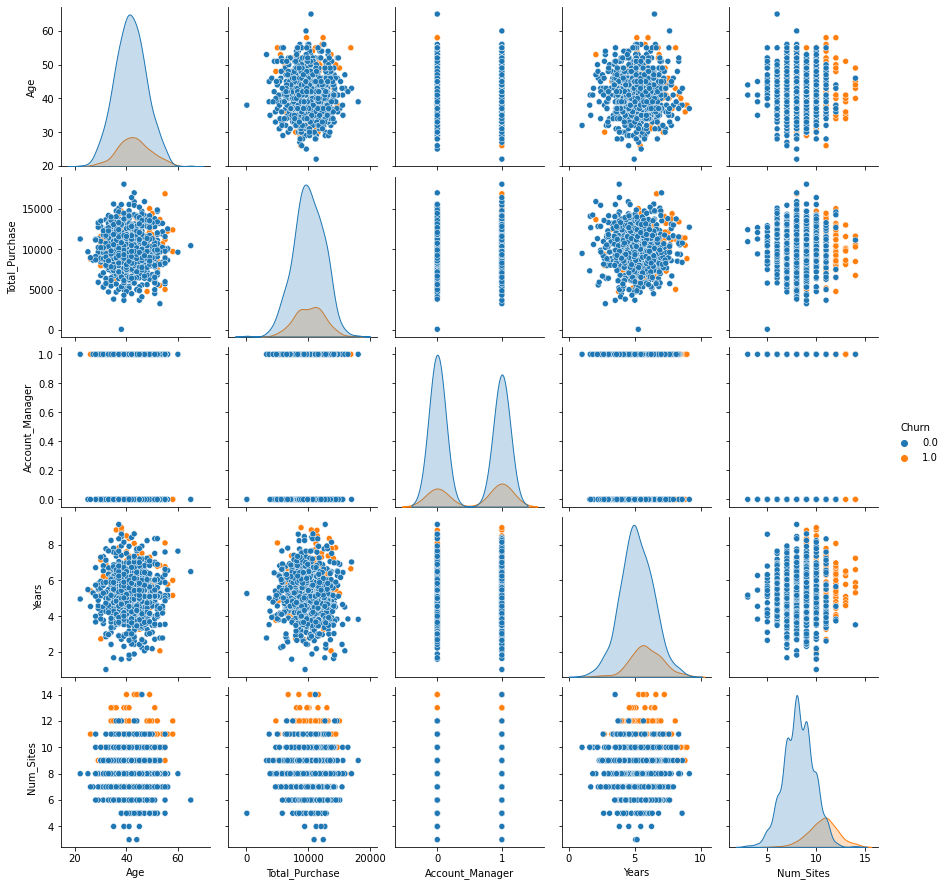

In [27]:
sns.pairplot(df,hue="Churn");

In [31]:
from __future__ import print_function

In [32]:
spark=SparkSession.builder.getOrCreate()


In [33]:
inputlines=df = spark.read.options(header = True, inferSchema = True).csv("churn.csv")

In [38]:
inputlines

DataFrame[_c0: int, Names: string, Age: double, Total_Purchase: double, Account_Manager: int, Years: double, Num_Sites: double, Churn: int]

In [39]:
df=inputlines.rdd.map(lambda x: x.split(","))


In [40]:
colnames=['Age','Total_Purchase','Account_Manager','Years','Num_Sites','Churn']


In [41]:
df1=inputlines

In [43]:
from  pyspark.ml.feature import VectorAssembler

In [44]:
vecAssembler = VectorAssembler(inputCols=['Age','Total_Purchase','Account_Manager','Years','Num_Sites'], outputCol="features")
df1= vecAssembler.transform(df1)
df1

DataFrame[_c0: int, Names: string, Age: double, Total_Purchase: double, Account_Manager: int, Years: double, Num_Sites: double, Churn: int, features: vector]

In [45]:
df1 = df1.drop("index", 'Age','Total_Purchase','Account_Manager','Years','Num_Sites')
df1

DataFrame[_c0: int, Names: string, Churn: int, features: vector]

In [46]:
df1 = df1.withColumnRenamed("Churn", "label")
df1

DataFrame[_c0: int, Names: string, label: int, features: vector]

In [47]:
trainTest=df1.randomSplit([0.5,0.5])
trainingDF=trainTest[0]
testDF=trainTest[1]

In [48]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score


In [49]:
gbt=GBTClassifier(featuresCol='features',maxIter=10)

In [50]:
gbt = gbt.fit(trainingDF)

In [51]:
predictions = gbt.transform(testDF)
predictions.show()

+---+-------------------+-----+--------------------+--------------------+--------------------+----------+
|_c0|              Names|label|            features|       rawPrediction|         probability|prediction|
+---+-------------------+-----+--------------------+--------------------+--------------------+----------+
|  0|   Cameron Williams|    1|[42.0,11066.8,0.0...|[1.10244933141402...|[0.90068855071628...|       0.0|
|  3|      Phillip White|    1|[42.0,8010.76,0.0...|[0.44294033155048...|[0.70803935512023...|       0.0|
|  4|     Cynthia Norton|    1|[37.0,9191.58,0.0...|[1.13525689711811...|[0.90640538442581...|       0.0|
|  5|   Jessica Williams|    1|[48.0,10356.02,0....|[1.20557610817102...|[0.91767377212935...|       0.0|
|  8|        Ashlee Carr|    1|[43.0,14062.6,1.0...|[-0.1902191390750...|[0.40602119405583...|       1.0|
| 11|     Bruce Phillips|    1|[45.0,8771.02,1.0...|[1.08438484243988...|[0.89740975236221...|       0.0|
| 12|       Craig Garner|    1|[45.0,8988.67,1